In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 75%; }
</style>
"""))

In [2]:
!dir

Nivida\ cnn\ standalone\ validation\ loss.png
Training.png
script
training_ground-handy-ca1_ca2_ca3.ipynb
training_ground-handy-ca1_ca2_ca3_ca4-25_50epochs.ipynb
training_ground-handy-ca1_ca2_ca3_ca4.ipynb
training_ground-handy.ipynb
training_ground.ipynb


In [3]:
from platform import python_version

print(python_version())

3.8.3


In [4]:
%matplotlib inline
import os
import sys
import gc
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

module_path_list = [os.path.abspath(os.path.join('../')), 
                    os.path.abspath(os.path.join('../../RCSnail-Commons'))]

for module_path in module_path_list:
    if module_path not in sys.path:
        sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
#from src.utilities.transformer import Transformer
from src.learning.training.generator import Generator, GenFiles
#from src.learning.models import create_standalone_nvidia_cnn, create_standalone_resnet
                                

In [5]:
def plot_stuff(title, plot_elem, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #x = np.arange(0, len(plot_elems[0]['data']), 1)
    
    #for plot_elem in plot_elems:
    #    plt.errorbar(x, plot_elem['data'], yerr=plot_elem['error'], label=plot_elem['label'], alpha=plot_elem['alpha'], fmt='-o', capsize=5)
    
    plt.plot(list(range(1,len(plot_elem['data'])+1)), plot_elem['data'])
    plt.grid(axis='both')
    #plt.legend(loc='best', prop={'size': 15})
    plt.show()
    plt.savefig('./' + title + '.png')

In [6]:
def create_standalone_nvidia_cnn(activation='linear', input_shape=(60, 180, 3), output_shape=1):
    """
    Activation: linear, softmax.
    Architecture is from nvidia paper mentioned in https://github.com/tanelp/self-driving-convnet/blob/master/train.py
    """
    from tensorflow.keras.layers import Convolution2D
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import mean_squared_error, mean_absolute_error

    inputs = Input(shape=input_shape)
    conv_1 = Convolution2D(24, kernel_size=(5, 5), kernel_regularizer=l2(0.0005), strides=(2, 2), padding="same", activation="elu")(inputs)
    conv_2 = Convolution2D(36, kernel_size=(5, 5), kernel_regularizer=l2(0.0005), strides=(2, 2), padding="same", activation="elu")(conv_1)
    conv_3 = Convolution2D(48, kernel_size=(5, 5), kernel_regularizer=l2(0.0005), strides=(2, 2), padding="same", activation="elu")(conv_2)
    conv_4 = Convolution2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.0005), padding="same", activation="elu")(conv_3)
    conv_5 = Convolution2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.0005), padding="same", activation="elu")(conv_4)
    flatten = Flatten()(conv_5)
    dense_1 = Dense(1164, kernel_regularizer=l2(0.0005), activation="elu")(flatten)
    dense_2 = Dense(100, kernel_regularizer=l2(0.0005), activation="elu")(dense_1)
    dense_3 = Dense(50, kernel_regularizer=l2(0.0005), activation="elu")(dense_2)
    dense_4 = Dense(10, kernel_regularizer=l2(0.0005), activation="elu")(dense_3)
    out_dense = Dense(output_shape, activation=activation)(dense_4)

    model = Model(inputs=inputs, outputs=out_dense)
    optimizer = Adam(lr=3e-4)
    model.compile(loss=mean_absolute_error, optimizer=optimizer)

    return model

# Handy Testing

In [7]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
from skimage.transform import rescale, resize, downscale_local_mean

import glob
import random
from PIL import Image
import PIL
 

In [8]:
import glob

# val_data_loc="preprocessed/cleaned_all"
# filenames = glob.glob("preprocessed/cleaned_all/*")
val_data_loc="../cleaned_all/"
filenames = glob.glob("../cleaned_all/*")
print(filenames[1])
print(int(len(filenames)/2))
nr_of_datapoints = int(len(filenames)/2) #label and image files
print(nr_of_datapoints)


MAEs=[]
preds=[]
labels=[]


../cleaned_all/frame_0083594.npy
154948
154948


In [9]:
frames = []
commands = []

# for batch in range(53482,53482+nr_of_datapoints): # using the end of file. 32 batches of size batch of 32
for batch in range(1,nr_of_datapoints): # using the end of file. 32 batches of size batch of 32
    frames.append(np.load(val_data_loc + "frame_"+str(batch).zfill(7)+".npy"))
    commands.append(np.load(val_data_loc + "commands_"+str(batch).zfill(7)+".npy"))

In [10]:
#frames = frames.reshape(1,60,180,3)
frames = np.array(frames)
frames.shape

(154947, 60, 180, 3)

In [11]:
#commands = commands.reshape(1, 2)
commands = np.array(commands)
commands.shape

(154947, 2)

### Fitting with 25 Epochs

In [12]:
model = create_standalone_nvidia_cnn(activation='linear', input_shape=(60, 180, 3), output_shape=2)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 180, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 90, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 45, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 23, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 23, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 23, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 11776)            

In [13]:
hist = model.fit(frames, commands, batch_size=64, epochs=25, validation_split=0.2)

losses = []
val_losses = []
current_loss = hist.history['loss']
current_val_loss = hist.history['val_loss'] 

losses.append(current_loss)
print(val_losses)
val_losses.append(current_val_loss)

tqdm.write("Loss per epoch: {}".format(current_loss))
tqdm.write("Validation loss per epoch: {}".format(current_val_loss))

gc.collect()

Epoch 1/25
1937/1937 [==============================] - 365s 188ms/step - loss: 1.0058 - val_loss: 0.6316
Epoch 2/25
1937/1937 [==============================] - 365s 189ms/step - loss: 0.4885 - val_loss: 0.3523
Epoch 3/25
1937/1937 [==============================] - 367s 189ms/step - loss: 0.3007 - val_loss: 0.2366
Epoch 4/25
1937/1937 [==============================] - 367s 189ms/step - loss: 0.2149 - val_loss: 0.1779
Epoch 5/25
1937/1937 [==============================] - 366s 189ms/step - loss: 0.1778 - val_loss: 0.1613
Epoch 6/25
1937/1937 [==============================] - 365s 189ms/step - loss: 0.1605 - val_loss: 0.1447
Epoch 7/25
1937/1937 [==============================] - 366s 189ms/step - loss: 0.1513 - val_loss: 0.1386
Epoch 8/25
1937/1937 [==============================] - 366s 189ms/step - loss: 0.1471 - val_loss: 0.1332
Epoch 9/25
1937/1937 [==============================] - 366s 189ms/step - loss: 0.1432 - val_loss: 0.1328
Epoch 10/25
1937/1937 [=======================

1533

[[0.6316397190093994, 0.35227158665657043, 0.23659703135490417, 0.17788924276828766, 0.16132840514183044, 0.1446753740310669, 0.13864755630493164, 0.1332198679447174, 0.13279351592063904, 0.13543206453323364, 0.12829375267028809, 0.12698809802532196, 0.12638358771800995, 0.1261308789253235, 0.1257925033569336, 0.12534312903881073, 0.12392742186784744, 0.12909403443336487, 0.13443954288959503, 0.1257123202085495, 0.12473315745592117, 0.12005911022424698, 0.11787658929824829, 0.11858492344617844, 0.12092545628547668]]
[0.6316397190093994, 0.35227158665657043, 0.23659703135490417, 0.17788924276828766, 0.16132840514183044, 0.1446753740310669, 0.13864755630493164, 0.1332198679447174, 0.13279351592063904, 0.13543206453323364, 0.12829375267028809, 0.12698809802532196, 0.12638358771800995, 0.1261308789253235, 0.1257925033569336, 0.12534312903881073, 0.12392742186784744, 0.12909403443336487, 0.13443954288959503, 0.1257123202085495, 0.12473315745592117, 0.12005911022424698, 0.11787658929824829, 

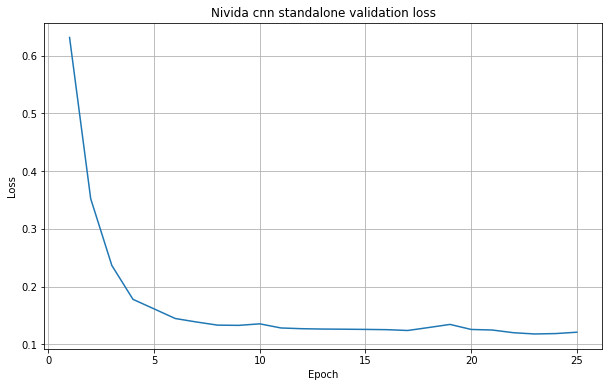

<Figure size 432x288 with 0 Axes>

In [14]:
print(val_losses)
print(hist.history['val_loss'] )
loss_data = []
val_loss_data = []


val_loss_data = {'data': hist.history['val_loss'], 'label': 'Validation loss', 'alpha': 1.0}
plot_stuff('Nivida cnn standalone validation loss', val_loss_data, figsize=(10, 6))

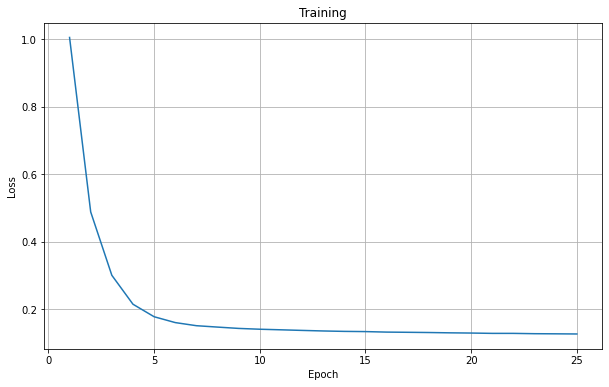

<Figure size 432x288 with 0 Axes>

In [15]:
loss_data = {'data': losses[0], 'label': 'Loss', 'alpha': 1.0}
plot_stuff('Training', loss_data, figsize=(10, 6))

In [16]:
mem_frame = frames[10].reshape(1,60,180,3)
mem_frame.shape
mem_frame

new_mem_frame = mem_frame

if(new_mem_frame.all() == mem_frame.all()):
    print("sama")

sama


In [17]:
model.predict(mem_frame)

array([[0.07971831, 0.43897474]], dtype=float32)

In [18]:
from datetime import datetime

# Get current timestamp | source: https://www.programiz.com/python-programming/datetime/current-datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")
print(now)

#plot_model(model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
model.save('../src/model_team_3_' + now + '_25epochs_ca1_ca2_ca3_ca4.h5')

20210120_043317


In [19]:
#todo load test set into memeory, evaluate
import keras
model = keras.models.load_model('../src/model_team_3_' + now + '_25epochs_ca1_ca2_ca3_ca4.h5')
import glob

val_data_loc="../cleaned_all"
filenames = glob.glob("../cleaned_all/*")
print(len(filenames))
nr_of_datapoints = int(len(filenames)/2) #label and image files


MAEs=[]
preds=[]
labels=[]

# for batch in range(53482//32,(53482+nr_of_datapoints)//32):
for batch in range(nr_of_datapoints//32-32,nr_of_datapoints//32):
# for batch in range(nr_of_datapoints//32-32,nr_of_datapoints//32): # using the end of file. 32 batches of size batch of 32
    frames=np.zeros((32,60,180,3))
    commands = np.zeros((32,2))
    for i in range(32):
#         frames.append(np.load(val_data_loc + "frame_"+str(batch).zfill(7)+".npy"))
#         commands.append(np.load(val_data_loc + "commands_"+str(batch).zfill(7)+".npy"))
#         frames[i,:] = np.load("../cleaned_all/frame_"+str(batch*32+i).zfill(7)+".npy")
#         commands[i] = np.load("../cleaned_all/commands_"+str(batch*32+i).zfill(7)+".npy")
        frames[i,:] = np.load("../cleaned_all/frame_"+str(batch).zfill(7)+".npy")
        commands[i] = np.load("../cleaned_all/commands_"+str(batch).zfill(7)+".npy")
    MAEs.append(model.evaluate(frames,commands, batch_size=32))
    pred = model.predict(frames)
    preds.append(pred)
    labels.append(commands)
    
print(np.mean(MAEs))

309896
1/1 [==============================] - 0s 691us/step - loss: 0.0331
0.06330698309466243


0.06330698309466243
(32, 32) (32, 32)


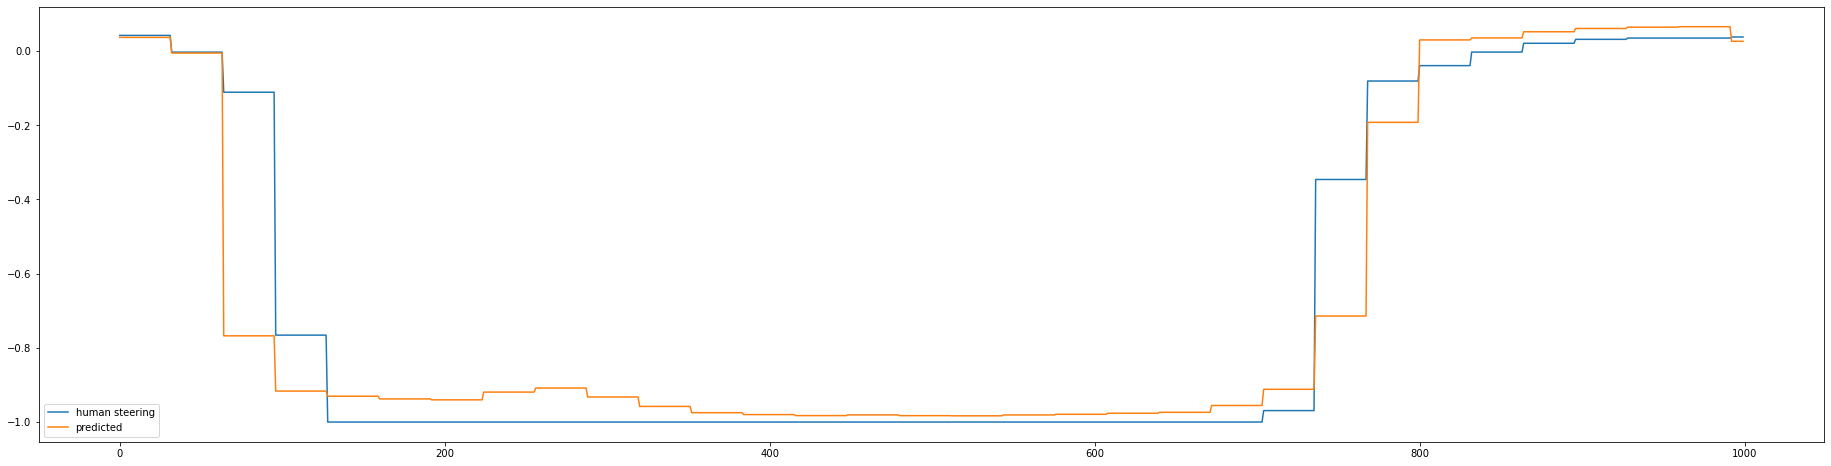

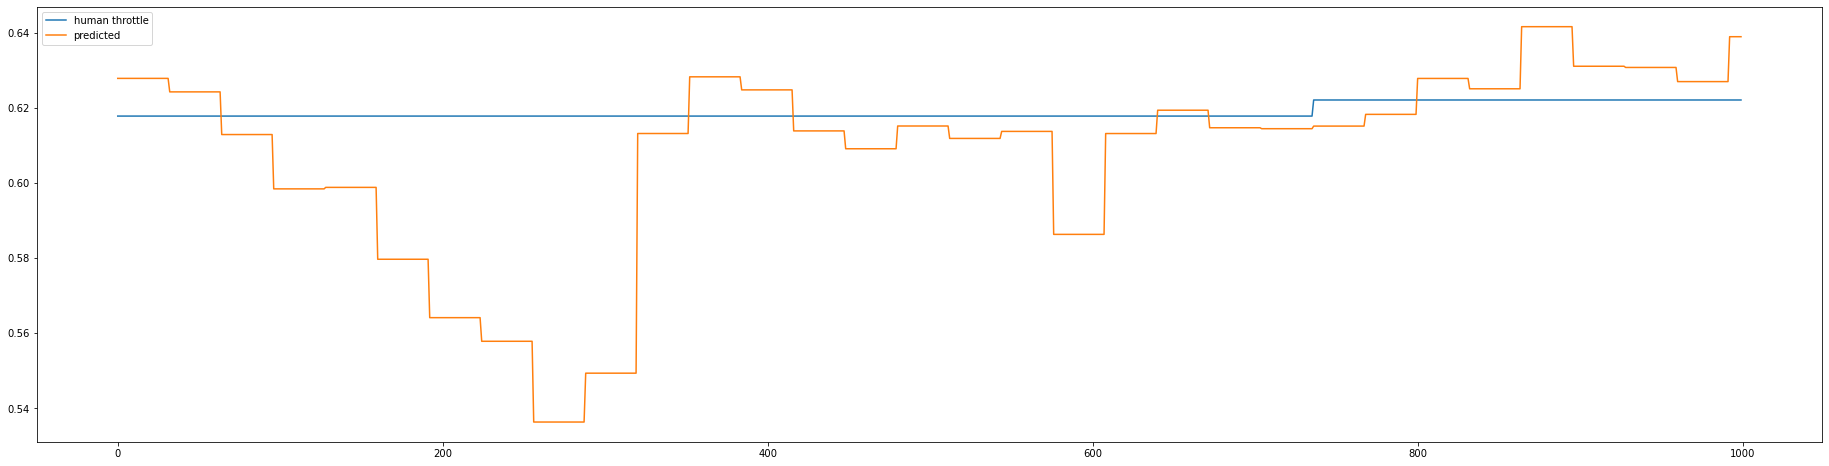

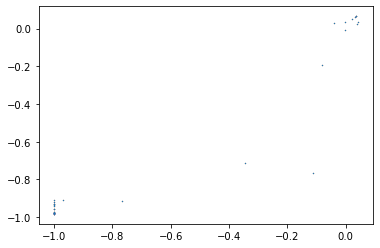

In [20]:
print(np.mean(MAEs))
p_steer=np.array(preds)[:,:,0]
l_steer=np.array(labels)[:,:,0]
p_throttle=np.array(preds)[:,:,1]
l_throttle=np.array(labels)[:,:,1]

print(p_steer.shape,l_steer.shape)
p_steer=p_steer.flatten()
l_steer=l_steer.flatten()
p_throttle=p_throttle.flatten()
l_throttle=l_throttle.flatten()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_steer[:1000],label="human steering")
plt.plot(range(1000),p_steer[:1000],label="predicted")
plt.legend()
plt.show()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_throttle[:1000],label="human throttle")
plt.plot(range(1000),p_throttle[:1000],label="predicted")
plt.legend()
plt.show()



plt.scatter(l_steer,p_steer,s=0.001)

### Fitting with 50 Epochs

In [21]:
model2 = create_standalone_nvidia_cnn(activation='linear', input_shape=(60, 180, 3), output_shape=2)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 180, 3)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 90, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 45, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 23, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 23, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 23, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 11776)            

In [22]:
hist = model2.fit(frames, commands, batch_size=64, epochs=50, validation_split=0.2)

losses = []
val_losses = []
current_loss = hist.history['loss']
current_val_loss = hist.history['val_loss'] 

losses.append(current_loss)
print(val_losses)
val_losses.append(current_val_loss)

tqdm.write("Loss per epoch: {}".format(current_loss))
tqdm.write("Validation loss per epoch: {}".format(current_val_loss))

gc.collect()

Epoch 1/50
1/1 [==============================] - 0s 113ms/step - loss: 5.6014 - val_loss: 5.3945
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 5.3945 - val_loss: 2.6264
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 2.6264 - val_loss: 3.2648
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 3.2648 - val_loss: 2.8299
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 2.8299 - val_loss: 2.5420
Epoch 6/50
1/1 [==============================] - 0s 21ms/step - loss: 2.5420 - val_loss: 1.5521
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 1.5521 - val_loss: 1.8302
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 1.8302 - val_loss: 3.9462
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 3.9462 - val_loss: 2.4090
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 2.4090 - val_loss: 2.0830
Epoch 11/50
1/1 [===========

19683

[[5.3944830894470215, 2.6264050006866455, 3.264829397201538, 2.8298580646514893, 2.5420050621032715, 1.5520552396774292, 1.8301748037338257, 3.9461724758148193, 2.4090209007263184, 2.082956552505493, 1.9947128295898438, 1.6676231622695923, 2.282109498977661, 2.244840145111084, 1.4460557699203491, 2.0003957748413086, 1.928931474685669, 1.8268991708755493, 1.6772624254226685, 1.603170394897461, 1.4596844911575317, 1.6728918552398682, 1.3861310482025146, 1.901764988899231, 1.865831971168518, 1.2457350492477417, 1.7568541765213013, 1.6375776529312134, 1.4521890878677368, 1.434403419494629, 1.4635382890701294, 1.3660527467727661, 1.6470085382461548, 1.4544963836669922, 1.609840750694275, 1.9349912405014038, 1.8235036134719849, 1.4450905323028564, 1.5351823568344116, 1.7158089876174927, 1.556627869606018, 1.3638288974761963, 1.6014384031295776, 1.6176882982254028, 1.3463281393051147, 1.5266482830047607, 1.6962611675262451, 1.5753238201141357, 1.2428053617477417, 1.412822961807251]]
[5.394483

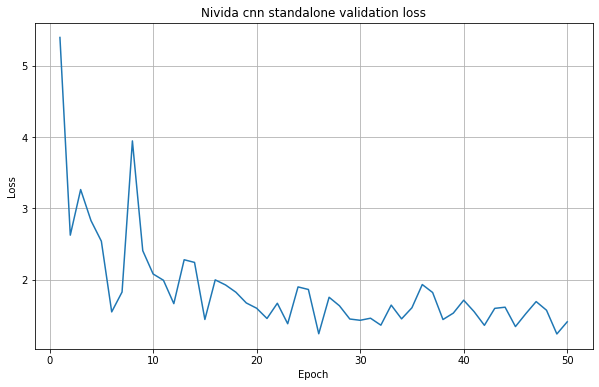

<Figure size 432x288 with 0 Axes>

In [23]:
print(val_losses)
print(hist.history['val_loss'] )
loss_data = []
val_loss_data = []


val_loss_data = {'data': hist.history['val_loss'], 'label': 'Validation loss', 'alpha': 1.0}
plot_stuff('Nivida cnn standalone validation loss', val_loss_data, figsize=(10, 6))

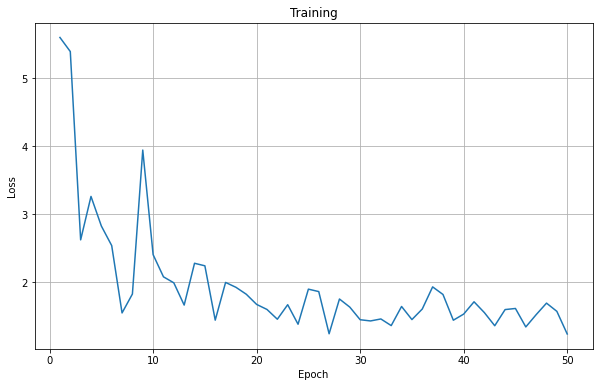

<Figure size 432x288 with 0 Axes>

In [24]:
loss_data = {'data': losses[0], 'label': 'Loss', 'alpha': 1.0}
plot_stuff('Training', loss_data, figsize=(10, 6))

In [25]:
mem_frame = frames[10].reshape(1,60,180,3)
mem_frame.shape
mem_frame

new_mem_frame = mem_frame

if(new_mem_frame.all() == mem_frame.all()):
    print("sama")

sama


In [26]:
model2.predict(mem_frame)

array([[0.24457985, 0.8999531 ]], dtype=float32)

In [27]:
from datetime import datetime

# Get current timestamp | source: https://www.programiz.com/python-programming/datetime/current-datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")
print(now)

#plot_model(model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
model2.save('../src/model_team_3_' + now + '_50epochs_ca1_ca2_ca3_ca4.h5')

20210120_043328


In [28]:
#todo load test set into memeory, evaluate
import keras
model = keras.models.load_model('../src/model_team_3_' + now + '_50epochs_ca1_ca2_ca3_ca4.h5')
import glob

val_data_loc="../cleaned_all"
filenames = glob.glob("../cleaned_all/*")
print(len(filenames))
nr_of_datapoints = int(len(filenames)/2) #label and image files


MAEs=[]
preds=[]
labels=[]

# for batch in range(53482//32,(53482+nr_of_datapoints)//32):
for batch in range(nr_of_datapoints//32-32,nr_of_datapoints//32):
# for batch in range(nr_of_datapoints//32-32,nr_of_datapoints//32): # using the end of file. 32 batches of size batch of 32
    frames=np.zeros((32,60,180,3))
    commands = np.zeros((32,2))
    for i in range(32):
#         frames.append(np.load(val_data_loc + "frame_"+str(batch).zfill(7)+".npy"))
#         commands.append(np.load(val_data_loc + "commands_"+str(batch).zfill(7)+".npy"))
#         frames[i,:] = np.load("../cleaned_all/frame_"+str(batch*32+i).zfill(7)+".npy")
#         commands[i] = np.load("../cleaned_all/commands_"+str(batch*32+i).zfill(7)+".npy")
        frames[i,:] = np.load("../cleaned_all/frame_"+str(batch).zfill(7)+".npy")
        commands[i] = np.load("../cleaned_all/commands_"+str(batch).zfill(7)+".npy")
    MAEs.append(model.evaluate(frames,commands, batch_size=32))
    pred = model.predict(frames)
    preds.append(pred)
    labels.append(commands)
    
print(np.mean(MAEs))

309896
1/1 [==============================] - 0s 599us/step - loss: 1.4128
1.6891241446137428


1.6891241446137428
(32, 32) (32, 32)


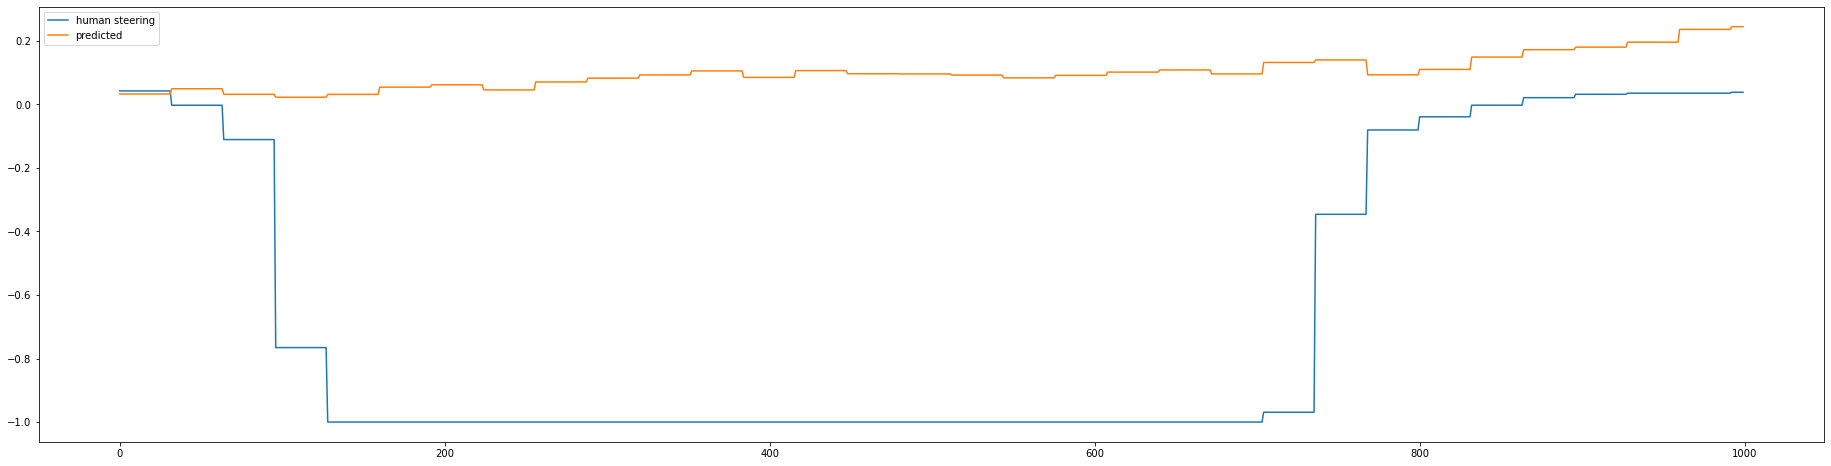

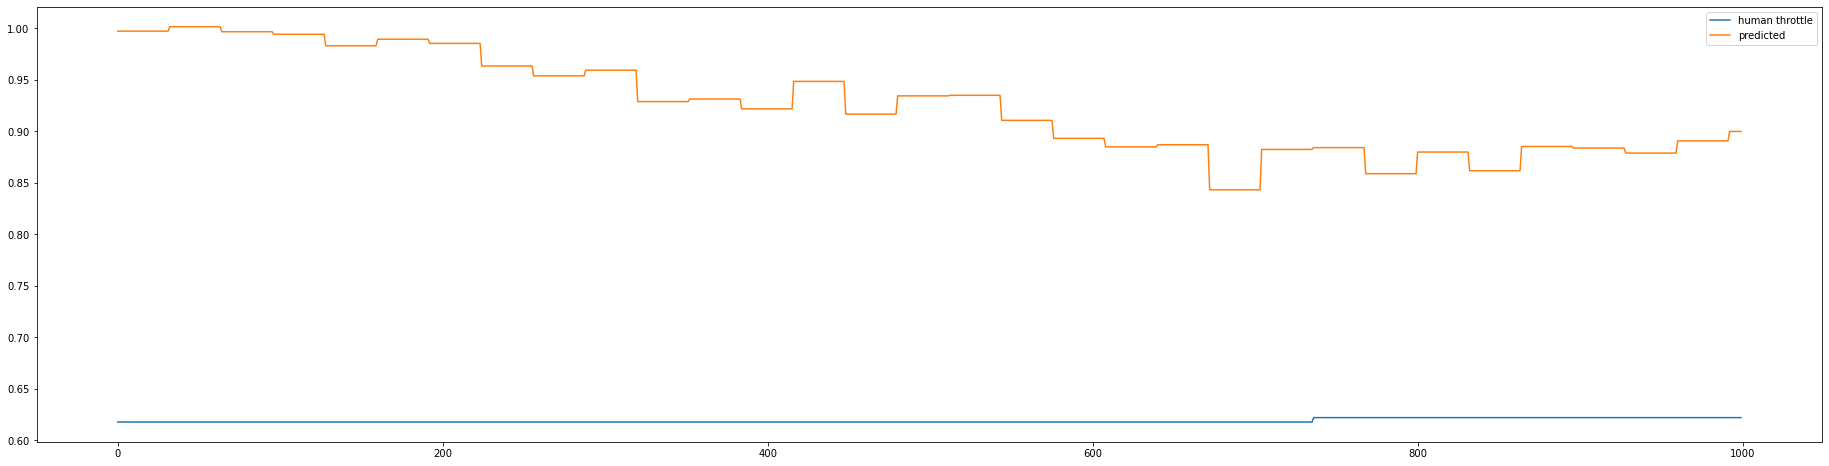

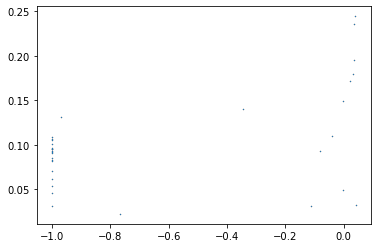

In [29]:
print(np.mean(MAEs))
p_steer=np.array(preds)[:,:,0]
l_steer=np.array(labels)[:,:,0]
p_throttle=np.array(preds)[:,:,1]
l_throttle=np.array(labels)[:,:,1]

print(p_steer.shape,l_steer.shape)
p_steer=p_steer.flatten()
l_steer=l_steer.flatten()
p_throttle=p_throttle.flatten()
l_throttle=l_throttle.flatten()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_steer[:1000],label="human steering")
plt.plot(range(1000),p_steer[:1000],label="predicted")
plt.legend()
plt.show()


plt.figure(figsize=(32,8))
plt.plot(range(1000),l_throttle[:1000],label="human throttle")
plt.plot(range(1000),p_throttle[:1000],label="predicted")
plt.legend()
plt.show()



plt.scatter(l_steer,p_steer,s=0.001)